In [1]:
import xarray as xr
import warnings
from pathlib import Path

from pyorg.core.geometry import get_cells_area

import pycompo.core.coord as pccoord
import pycompo.core.ellipse as pcellipse
import pycompo.core.feature_cutout as pcfeatcut
import pycompo.core.filter as pcfilter
import pycompo.core.plot as pcplot
import pycompo.core.sst_features as pcsst
import pycompo.core.wind as pcwind
import pycompo.core.significance_testing as pcsig

from pycompo.core.composite import get_compo_coords_ds
from pycompo.core.utils import read_yaml_config, circ_roll_avg

warnings.filterwarnings(action='ignore')

# read in configuration file
#config_file = "/home/m/m300738/libs/pycompo/config/settings_ngc5004_pc03.yaml"
config_file = "/home/m/m300738/libs/pycompo/config/settings_ifs_tco3999-ng5_deepoff_pc05.yaml"
config = read_yaml_config(config_file)

start_time = config['data']['analysis_time'][0]
end_time = config['data']['analysis_time'][1]
feature_var = config['data']['feature_var']

### Read in data, building SST anomalies and their gradients using Gaussian filter

#### Infos on the filtering in degree space
Here we use a characteristic wavelength in degree since this has three advantages:
1) We remove the necessity to transform to km and can easily use a Gaussian filter
2) Ocean eddies - and thus temperature anomalies - tend to become smaller towards higher latitudes due to the Coriolis effect. Thus, cutting at a certain wavenumber instead of a certain wavelength is also physically reasonable.
3) We are in the deep tropics where the difference between longitudes and distances is small anyways.

Nevertheless, the charcateristic wavenumber has to be submitted as a characteristic wavelength at the equator -- it will be transformed internally.

In [ ]:
varlist = [feature_var] + config['data']['wind_vars'] + \
    config['data']['study_vars']

infiles = []
for var in varlist:
    inpath = Path(config['data']['inpaths'][var])
    in_pattern = \
        f"{config['exp']}_tropical_{var}_20200801T000000Z-20200901T000000Z.nc"
    infiles.extend(sorted([str(f) for f in inpath.rglob(in_pattern)]))
dset = xr.open_mfdataset(infiles, parallel=True).squeeze()
dset = dset.isel(time=slice(0, 2))

# Detrend data with climatology
if config['detrend']['switch']:
    feature_var = config['data']['feature_var']

    # Read in data for building the climatology
    inpath = Path(config['data']['inpaths'][feature_var])
    in_pattern = f"{config['exp']}_tropical_{feature_var}_*.nc"
    infiles = sorted([str(f) for f in inpath.rglob(in_pattern)])
    dset_clim = xr.open_mfdataset(infiles, parallel=True).squeeze()
    
    # Detrend dataset with multiyear monthly climatology
    climatology = pcfilter.build_hourly_climatology(
        dset_clim, clim_baseyear=str(config['detrend']['clim_baseyear'])
        )
    rolling_climatology = circ_roll_avg(
        climatology, config['detrend']['clim_avg_days'], config['data']['spd'],
        )
    dset[f'{feature_var}_detrend'] = \
        dset[feature_var] - rolling_climatology[feature_var]
    dset[f'{feature_var}_detrend'] = dset[f'{feature_var}_detrend'].compute()
    config['data']['feature_var'] = f'{feature_var}_detrend'
    
for var in varlist: dset[var] = dset[var].compute()

# scale separation
filter_vars = [feature_var] + config['data']['study_vars'] + config['data']['wind_vars']
dset_filter = pcfilter.get_gaussian_filter_bg_ano(
    dset[filter_vars], **config['filter']
    )
dset_bg = dset_filter[[f"{var}_bg" for var in filter_vars]]
dset_ano = dset_filter[[f"{var}_ano" for var in filter_vars]]
dset_ano = pccoord.calc_sphere_gradient_laplacian(
    dset_ano, f'{feature_var}_ano',
    )

dset = xr.merge([dset[config['data']['wind_vars']], dset_ano])
dset['cell_area'] = get_cells_area(dset)
dset = dset.sel(lat=slice(*config['lat_range']), drop=True)

### Visualization of the different SST preprocessing steps

In [3]:
if config['detrend']['switch']:
    # User settings of spatiotemporal plotting area
    lat_slice = slice(0, 10)
    lat_slice = slice(-15, 15)
    lon_slice = slice(-170, -160)
    lon_slice = slice(-179, -140)
    time_index = 0

    pcplot.plot_preprocessing_overview_map(
        dset.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice),
        config['data']['feature_var'], config['feature']['threshold'], 
        )

### Detection of SST clusters and cutout of corresponding data

In [ ]:
dset[f"{feature_var}_feature"], feature_props = \
    pcsst.extract_sst_features(dset[f"{feature_var}_ano"], **config['feature'])
dset, feature_props, feature_data = pcfeatcut.get_featcen_data_cutouts(
    dset, feature_props, feature_var, config['cutout']['search_RadRatio'],
    )
feature_props = pcwind.calc_feature_bg_wind(
    feature_props, feature_data, config['data']['wind_vars'], calc_sfcwind=True,
    )

orig_coords = pccoord.get_coords_orig(dset)
feature_ellipse = pcellipse.get_ellipse_params(feature_props, orig_coords)
feature_data = pccoord.add_featcen_coords(
    orig_coords, feature_data, feature_props, feature_ellipse,
    )
feature_data = pcwind.add_wind_grads(feature_data, feature_props, feature_var)
#feature_data = pcwind.add_rotate_winds(feature_data, feature_props)
feature_compo_data = get_compo_coords_ds(feature_data, feature_var, config)

# Significance tests
_, pvalue = pcsig.calc_compo_ttest(feature_compo_data, popmean=0.0)
local_significane = pcsig.get_local_significance(pvalue, alpha=0.05)
field_significane = pcsig.get_field_significance(pvalue, alpha_FDR=0.1)

### Visualization

#### Remapping

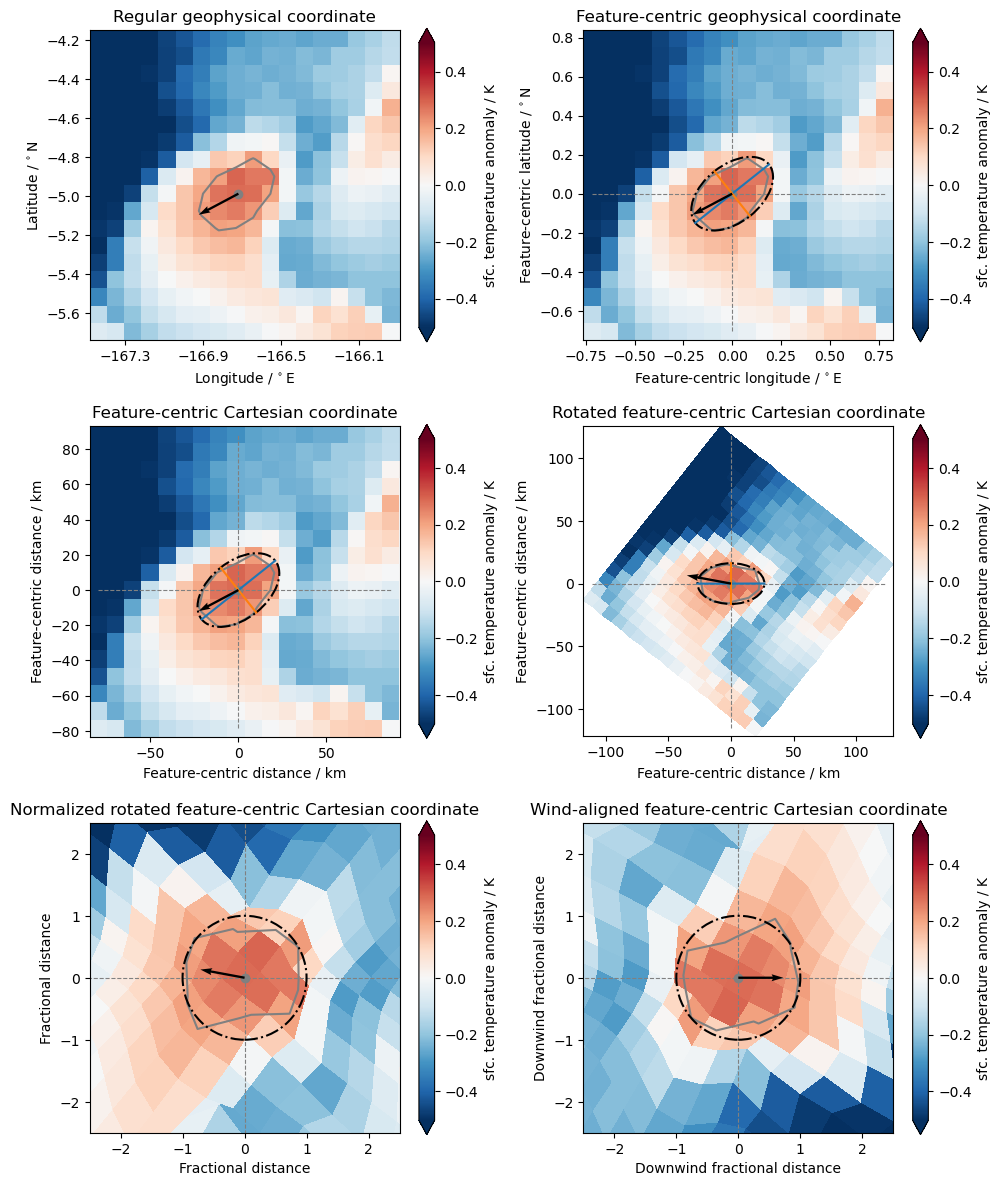

In [ ]:
import importlib as implib
implib.reload(pcplot)

feature_id = 103 #38
wind = feature_props[['bg_uas', 'bg_vas']]
pcplot.plot_coord_trafo(
    feature_data, feature_ellipse, wind, feature_id,
    f"{feature_var}_ano", config['feature']['threshold'],
    )

#### Composites

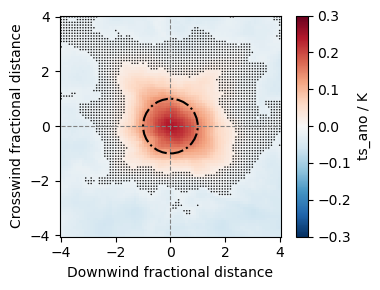

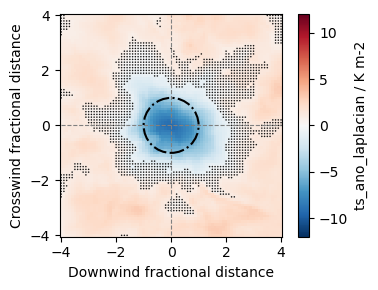

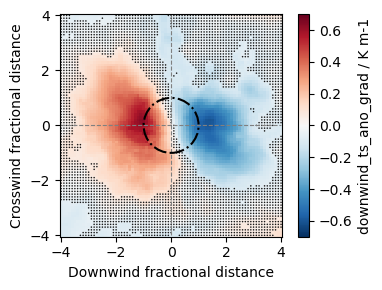

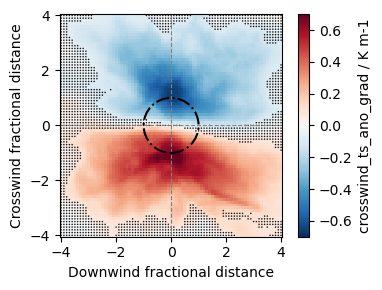

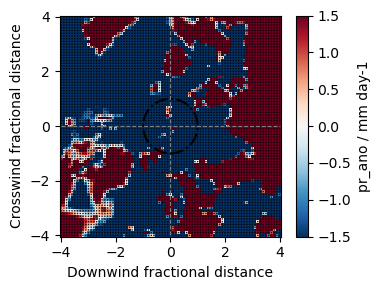

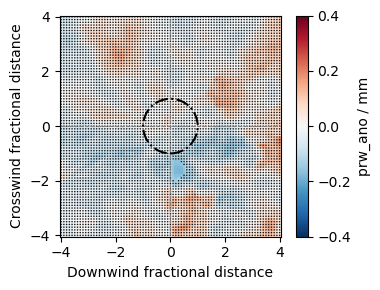

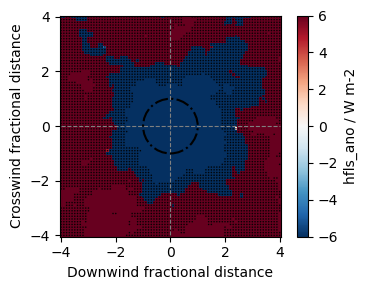

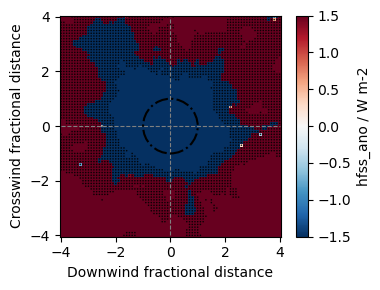

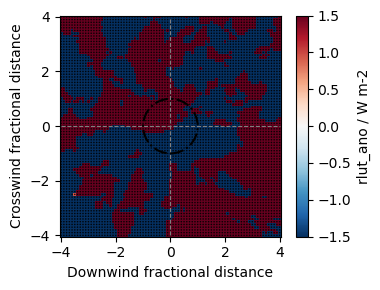

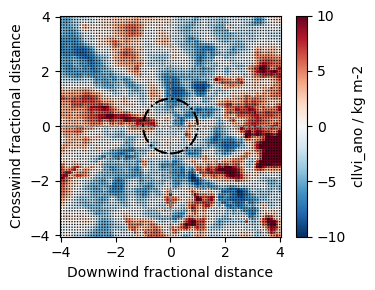

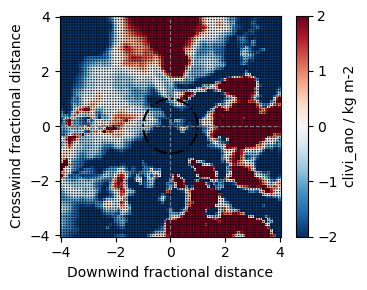

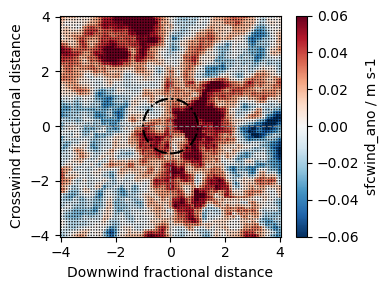

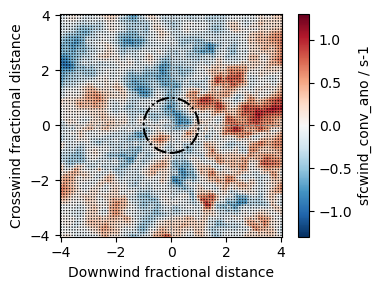

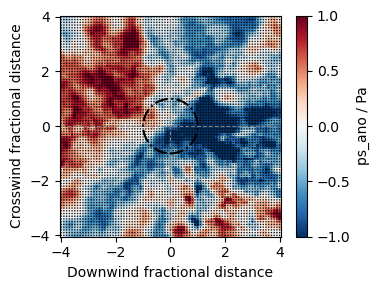

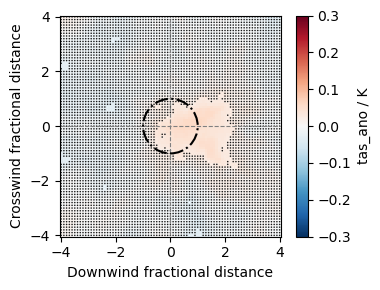

In [10]:
import importlib as implib
implib.reload(pcplot)
import pycompo.core.composite as pccompo

for var in feature_compo_data.data_vars:
    plot_data = pccompo.adjust_units(feature_compo_data, [var])
    pcplot.plot_composite(
        plot_data[var].mean(dim='feature'), field_significane[var],
        )

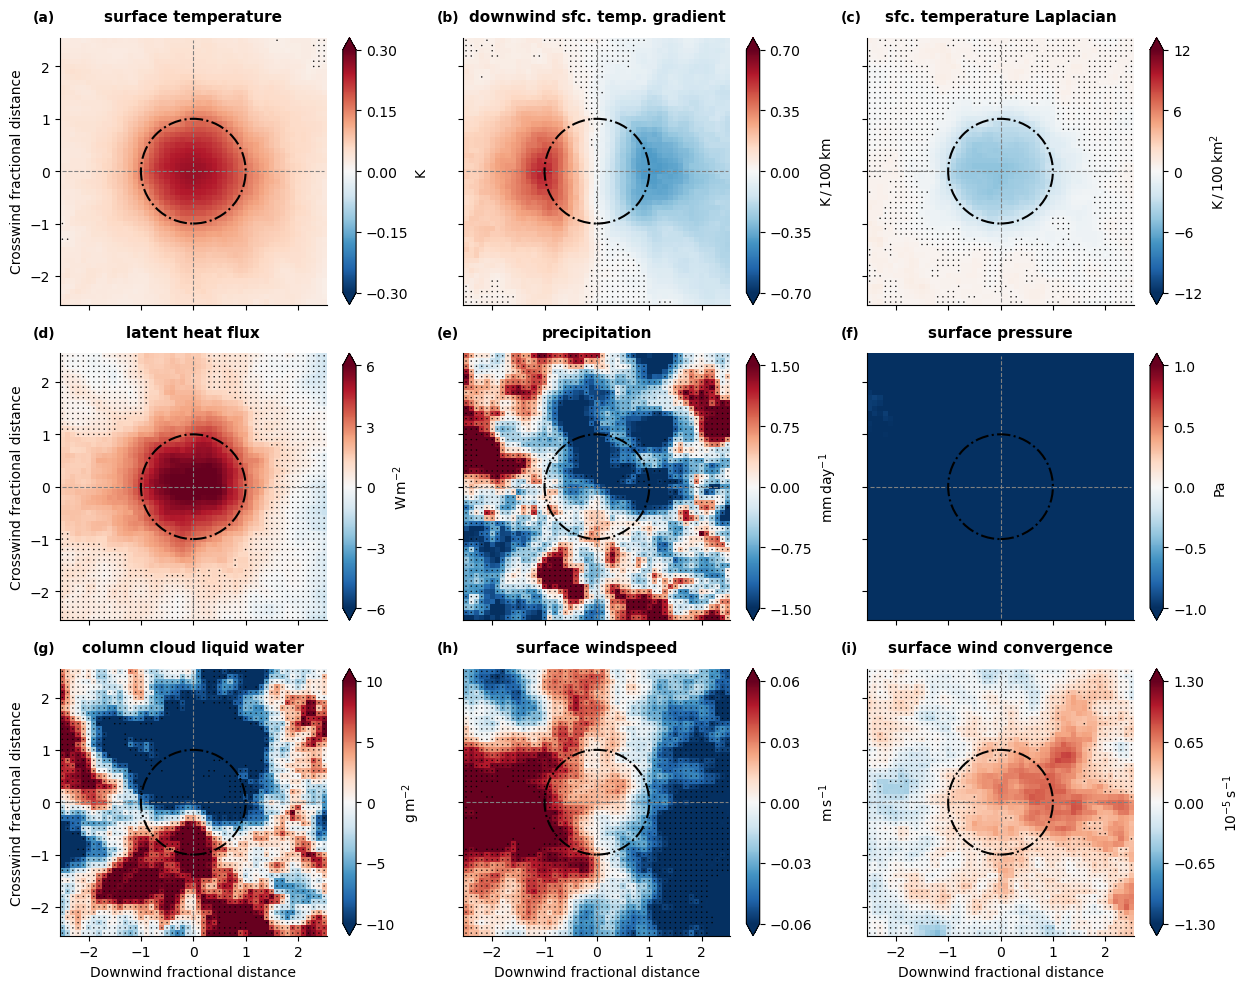

In [59]:
import importlib as implib
implib.reload(pcplot)

vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano', 'pr_ano',
    'ps_ano', 'cllvi_ano', 'sfcwind_ano', 'sfcwind_conv_ano']

pcplot.plot_composite_overview(
    pccompo.adjust_units(feature_compo_data.mean(dim='feature'), vars),
    sigmask, vars,
    )